---
title: Spatial Temporal
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
# @dataclass
# class Subset:
#     _target_: str = "slice"
#     _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-10"])

In [6]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-10"])


# @dataclass
# class SSHDM:
#     _target_: str = "jejeqx._src.datamodules.natl60.SSHSTNATL60"
#     batch_size: int = 10_000
#     shuffle: bool = False
#     split_method: str = "random"
#     train_size: float = 0.80
#     spatial_coords: List = field(default_factory=lambda : ["x", "y", "z"])
#     temporal_coords: List = field(default_factory=lambda: ["time"])
#     variables: List = field(default_factory=lambda : ["ssh"])
#     coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
#     directory: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/"
    
    
@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    subset_size: float = 0.40
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["sossheig"])
    coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
    resample: str = "1D"
    # paths: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
    paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"
    

# # spatial transform
# transforms = Pipeline([
#     ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
#     ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
#     ("timedelta", TimeDelta("2012-10-01", 1, "s")),
#     ("timeminmax", MinMaxDF(["time"], -1, 1)),
# ])

# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])

In [7]:
select = {"time": slice("2013-01-01", "2013-01-15")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms,
)

dm.setup()



init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/scaling.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.columns] = X_var


(-0.8150407127247838, 0.937432030206768, (32, 3), -1.0, 1.0, (32, 1))

In [8]:
len(dm.ds_train), len(dm.ds_test)

(108000, 337500)

In [9]:
xrda = dm.load_xrds()

In [10]:
# import geoviews as gv
# import geoviews.feature as gf
# from cartopy import crs

# gv.extension('bokeh', 'matplotlib')

In [11]:
xrda

<xarray.Dataset>
Dimensions:   (time: 15, lat: 150, lon: 150)
Coordinates:
  * lon       (lon) float64 -64.96 -64.89 -64.83 -64.76 ... -55.16 -55.09 -55.03
  * lat       (lat) float64 33.04 33.11 33.17 33.24 ... 42.77 42.84 42.91 42.97
  * time      (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-15
Data variables:
    sossheig  (time, lat, lon) float32 0.5274 0.519 0.5105 ... -0.1825 -0.1765
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [12]:
# dataset = gv.Dataset(xrda)
# ensemble1 = dataset.to(gv.Image, ['lon', 'lat'], "ssh")
# ensemble2 = dataset.to(gv.Image, ['lon', 'lat'], "ssh_lmsiren")
# gv.output(ensemble1.opts(cmap='viridis', colorbar=True, fig_size=200, backend='matplotlib') * gf.coastline(),
#           backend='matplotlib')

In [13]:
# dataset = gv.Dataset(xrda)
# ensemble = dataset.to(gv.Image, ['lon', 'lat'], "ssh_lmsiren")

# gv.output(ensemble.opts(cmap='viridis', colorbar=True, fig_size=200, backend='matplotlib') * gf.coastline(),
#           backend='matplotlib')

In [14]:
# lr = 5e-3
# num_epochs = 5_000
# num_steps_per_epoch = len(dm.ds_train)

# @dataclass
# class FoxDataModule:
#     _target_: str = "jejeqx._src.datamodules.image.ImageFox"
#     batch_size: int = 10_000
#     train_size: float = 0.5
#     shuffle: bool = False
#     split_method: str = "even"
#     resize: int = 4
    
# @dataclass
# class Training:
#     num_epochs: int = 2_000

# @dataclass
# class Model:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 2
#     out_size: int = 3
#     width_size: int = 128
#     depth: int = 5

# @dataclass
# class Optimizer:
#     _target_: str = "optax.adam"
#     learning_rate: float = lr
    
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = lr
#     warmup_steps: int = 100
#     decay_steps: int = int(num_epochs * num_steps_per_epoch)
#     end_value: float = 0.01 * lr
    
# @dataclass
# class Config:
#     datamodule: FoxDataModule = FoxDataModule()
#     model: Model = Model()
#     optimizer: Optimizer = Optimizer()
#     scheduler: Scheduler = Scheduler()
#     num_epochs: int = 2_000

In [15]:
# import optax

# config = Config()
# config = OmegaConf.structured(Config())

# # initialize datamodule
# dm = hydra.utils.instantiate(config.datamodule)

# dm.setup()


# # initialize optimizer
# optimizer = hydra.utils.instantiate(config.optimizer)

# # initialize scheduler
# num_steps_per_epoch = len(dm.ds_train)
# decay_steps = int(num_steps_per_epoch * config.num_epochs)
# schedule_fn = hydra.utils.instantiate(config.scheduler, decay_steps=decay_steps)

# # initialize optimizer + scheduler
# optimizer = optax.chain(optimizer, optax.scale_by_schedule(schedule_fn))



In [16]:
# ibatch = next(iter(dm.train_dataloader()))

# print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

**Identity**

$$
\gamma_T(t) = t
$$

In [17]:
from jejeqx._src.nets import time_net

latent_dim = 128

time_encoder = time_net.TimeIdentity(out_features=latent_dim, key=jrandom.PRNGKey(123))

out = time_encoder(t_init[0])

assert out.shape == (latent_dim,)

out_batch = jax.vmap(time_encoder)(t_init)

assert out_batch.shape == (t_init.shape[0],latent_dim)

out_batch.min(), out_batch.max()

(Array(-1., dtype=float64), Array(1., dtype=float64))

**Linear**

$$
\gamma_T(t) = \mathbf{w}t + \mathbf{b}
$$

In [18]:
latent_dim = 128

time_encoder = eqx.nn.Linear(
    in_features=1, out_features=latent_dim, key=jrandom.PRNGKey(123)
)


out = time_encoder(t_init[0])

assert out.shape == (latent_dim,)

out_batch = jax.vmap(time_encoder)(t_init)

assert out_batch.shape == (t_init.shape[0],latent_dim)

out_batch.min(), out_batch.max()

(Array(-1.70982319, dtype=float64), Array(1.7617026, dtype=float64))

**Tanh**

$$
\gamma_T(t) = \tanh\left(\mathbf{w}t+\mathbf{b}\right)
$$

In [19]:
latent_dim = 128

time_encoder = time_net.TimeTanh(
    in_features=1, out_features=latent_dim, 
    use_bias=True,
    key=jrandom.PRNGKey(123)
)

out = time_encoder(t_init[0])

assert out.shape == (latent_dim,)

out_batch = jax.vmap(time_encoder)(t_init)

assert out_batch.shape == (t_init.shape[0],latent_dim)

out_batch.min(), out_batch.max()

(Array(-0.93662585, dtype=float64), Array(0.94269286, dtype=float64))

**Log**

$$
\gamma_T(t) = \log\left(\exp\left(\mathbf{w}t+\mathbf{b}\right) +1\right)
$$

In [20]:
latent_dim = 128

time_encoder = time_net.TimeLog(
    in_features=1, out_features=latent_dim, 
    use_bias=True,
    key=jrandom.PRNGKey(123)
)

out = time_encoder(t_init[0])

assert out.shape == (latent_dim,)

out_batch = jax.vmap(time_encoder)(t_init)

assert out_batch.shape == (t_init.shape[0],latent_dim)

out_batch.min(), out_batch.max()

(Array(0.16627497, dtype=float64), Array(1.92020283, dtype=float64))

**Fourier**

$$
\gamma_T(t) = \log\left(\exp\left(\mathbf{w}t+\mathbf{b}\right) +1\right)
$$

In [21]:
latent_dim = 128
bounded = True
time_encoder = time_net.TimeFourier(
    in_features=1, out_features=latent_dim, 
    bounded=bounded,
    key=jrandom.PRNGKey(123)
)

out = time_encoder(t_init[0])

assert out.shape == (latent_dim,)

out_batch = jax.vmap(time_encoder)(t_init)

assert out_batch.shape == (t_init.shape[0],latent_dim)

out_batch.min(), out_batch.max()

(Array(-0.49999261, dtype=float64), Array(0.49999261, dtype=float64))

#### Positional Encoding

In [18]:
from jejeqx._src.nets.nerfs import encoders

#### Gaussian Random Features


Source:

* [Blog](https://gregorygundersen.com/blog/2019/12/23/random-fourier-features/)
* [Tutorial](https://random-walks.org/content/misc/rff/rff.html)

In [19]:
latent_dim = 128
in_dim = 1
sigma = 1.0
key = key = jrandom.PRNGKey(42)

projection = jnp.eye(in_dim)

time_encoder = encoders.GaussianFourierFeatureEncoding(in_dim=in_dim, num_features=latent_dim, sigma=sigma, key=key)

out = time_encoder(t_init[0])

assert out.shape[-1] == time_encoder.out_dim

out_batch = jax.vmap(time_encoder)(t_init)

out.shape, out_batch.shape

assert out_batch.shape[-1] == time_encoder.out_dim

#### Identity

In [20]:
latent_dim = 128
in_dim = 1

projection = jnp.eye(in_dim)

time_encoder = encoders.IdentityEncoding(in_dim=in_dim)

out = time_encoder(t_init[0])

assert out.shape[-1] == time_encoder.out_dim

out_batch = jax.vmap(time_encoder)(t_init)

assert out_batch.shape[-1] == time_encoder.out_dim

#### NeRF-Like Positional Encoding

*NeRF - Neural Radiance Fields*

In [21]:
latent_dim = 128
in_dim = 1

projection = jnp.eye(in_dim)

time_encoder = encoders.SinusoidalEncoding(in_dim=in_dim, num_features=latent_dim)

out = time_encoder(t_init[0])

assert out.shape[-1] == time_encoder.out_dim

out_batch = jax.vmap(time_encoder)(t_init)

out.shape, out_batch.shape

assert out_batch.shape[-1] == time_encoder.out_dim

### SIREN Layer

$$
\boldsymbol{\phi}^{(\ell)}(\mathbf{x}) = \sin
\left(
\omega^{(\ell)}\left(
\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} + \mathbf{s}^{(\ell)}
\right)\right)
$$

where $\mathbf{s}$ is the modulation

$$
\mathbf{s}^{(\ell)} = \mathbf{w}_z^{(\ell)}\mathbf{z} + \mathbf{b}_z^{(\ell)}
$$

In [41]:
latent_dim = 64

@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123
    
@dataclass
class Activation:
    # _target_: str = "jejeqx._src.nets.activations.Tanh"
    _target_: str = "jejeqx._src.nets.activations.ReLU"
    
@dataclass
class IdentityAct:
    _target_: str = "equinox.nn.Identity"

@dataclass
class ModSirenBasis:
    _target_: str = "jejeqx._src.nets.nerfs.siren.LatentModulatedSirenNet"
    in_size: int = 3
    out_size: int = 128
    width_size: int = 128
    depth: int = 4
    latent_dim: int = latent_dim
    latent_width: int = 64
    latent_depth: int = 1
    key: Key = Key()
    
# @dataclass
# class ParamNet:
#     _target_: str = "equinox.nn.MLP"
#     in_size: int = 1
#     out_size: int = 128
#     width_size: int = 128
#     depth: int = 1
#     activation: Activation = Activation()
#     final_activation: IdentityAct = IdentityAct()
#     key: Key = Key(seed=42)


# @dataclass
# class ParamNet:
#     _target_: str = "jejeqx._src.nets.time_net.TimeFourier"
#     in_features: int = 1
#     out_features: int = 128
#     lmbd: float = 0.5
#     bounded: bool = True
#     key: Key = Key()

@dataclass
class TimeEncoder:
    # _target_: str = "jejeqx._src.nets.nerfs.encoders.SinusoidalEncoding"
    _target_: str = "jejeqx._src.nets.time_net.TimeLog"
    in_features: int = 1
    out_features: int = 128
    key: Key = Key()
    
@dataclass
class TimeNet:
    _target_: str = "equinox.nn.MLP"
    in_size: int = TimeEncoder().out_features
    out_size: int = latent_dim
    width_size: int = 64
    depth: int = 0
    activation: Activation = Activation()
    final_activation: IdentityAct = IdentityAct()
    key: Key = Key(seed=42)
    
@dataclass
class ParamNet:
    _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
    basis_net: TimeEncoder = TimeEncoder()
    network: TimeNet = TimeNet()
    
@dataclass
class LinearModel:
    _target_: str = "equinox.nn.Linear"
    in_features: int = ModSirenBasis().out_size
    out_features: int = 1
    use_bias: bool = True
    key: Key = Key()

    
@dataclass
class NerFModel:
    _target_: str = "jejeqx._src.nets.nerfs.base.ShapeParamNerF"
    mod_shape_net: ModSirenBasis = ModSirenBasis()
    param_net: ParamNet = ParamNet()
    network: LinearModel = LinearModel()

In [42]:
# initialize model
model_config = OmegaConf.structured(NerFModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model, in_axes=(0,0))(x_init, t_init)

assert out.shape == y_init.shape
# eqx.tree_pprint(model)

In [43]:
# model

In [44]:
# save_name = "./checkpoint_model_lmsiren_ssh.ckpt"
# model_mod_shape_net = eqx.tree_deserialise_leaves(f"{save_name}", model.mod_shape_net)

# # To partially load weights: in this case load everything except the final layer.
# model = eqx.tree_at(lambda model: model.mod_shape_net, model, model_mod_shape_net)

In [45]:
# model

In [17]:
from jejeqx._src.nets.nerfs.ffn import RFFLayer

model_name = "rff"


model = eqx.nn.Sequential(
    [RFFLayer(in_dim=4, num_features=256, out_dim=256, key=jrandom.PRNGKey(42)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(123)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(23)),
     RFFLayer(in_dim=256, num_features=256, out_dim=1, key=jrandom.PRNGKey(32)),
    ]
)

# model = eqx.nn.Sequential(
#     [RFFARD(in_dim=4, num_features=512, key=jrandom.PRNGKey(42)),
#      eqx.nn.Linear(in_features=1024, out_features=1, key=jrandom.PRNGKey(321)),
#      # RFFARD(in_dim=256, num_features=128, key=jrandom.PRNGKey(32)),
#      # eqx.nn.Linear(in_features=256, out_features=128, key=jrandom.PRNGKey(123)),
#      # RFFARD(in_dim=128, num_features=64, key=jrandom.PRNGKey(21)),
#      # eqx.nn.Linear(in_features=128, out_features=1, key=jrandom.PRNGKey(123)),
#     ]
#         )
# # network = equinox.nn.Linear()
# check output of models
out = jax.vmap(model)(jnp.hstack([x_init,t_init]))

assert out.shape == y_init.shape

## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `1_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

In [18]:
@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 1e-4

In [19]:
optim_config = OmegaConf.structured(Optimizer())

optim = hydra.utils.instantiate(optim_config)

### Scheduler

<p align="center">
<img src="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png" alt="drawing" width="300"/>
<figcaption align = "center">
  <b>Fig.1 - An example for learning rate reduction when the validation loss stagnates. Source: 
    <a href="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png">Blog</a>
  </b>
  </figcaption>
</p>

We will use a simple learning rate scheduler - `reduce_lr_on_plateau`. This will automatically reduce the learning rate as the validation loss stagnates. It will ensure that we really squeeze out as much performance as possible from our models during the training procedure.We start with a (relatively) high `learning_rate` of `1e-4` so we will set the `patience` to 5 epochs. So if there is no change in with every epoch, we decrease the learning rate by a factor of `0.1`.

This is a rather crude (but effective) method but it tends to work well in some situations. A better method might be the `cosine_annealing` method or the `exponential_decay` method. See other [examples](https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/).

In [20]:
import optax

num_epochs = 6_000

@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e0
    warmup_steps: int = 500
    end_value: float = 1e-5
    
# # FINETUNE!
# num_epochs = 5_000
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = 1e-2
#     warmup_steps: int = 500
#     end_value: float = 1e-6
    
scheduler_config = OmegaConf.structured(Scheduler())

In [21]:

num_steps_per_epoch = len(dm.ds_train)

scheduler = hydra.utils.instantiate(
    scheduler_config, decay_steps=int(num_epochs * num_steps_per_epoch)
)

In [22]:
optimizer = optax.chain(optim, optax.scale_by_schedule(scheduler))

## Trainer Module

In [31]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )
        
    @property
    def model(self):
        return self.state.params

    @property
    def model_batch(self):
        return jax.vmap(self.state.params, in_axes=(0,0))

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            # x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            # pred = jax.vmap(model, in_axes=(0,0))(x, t)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics
        
        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}

        def test_step(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            out = jax.vmap(model)(jnp.hstack([x, t]))
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return out, {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x, t = batch["spatial"], batch["temporal"]
            out = jax.vmap(model)(jnp.hstack([x, t]))
            return out

        return train_step, eval_step, test_step, predict_step
    
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [32]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = True
save_new = True

In [33]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 3.64 s, sys: 120 ms, total: 3.76 s
Wall time: 2.91 s


{'loss': 0.24346492231079037, 'psnr': 8.435205771453237}

In [37]:
# trainer.load_model("./checkpoints/checkpoint_model_stlmsiren_ssh_more.ckpt")
trainer.load_model("./checkpoints/checkpoint_natl60_model_rff.ckpt")

In [38]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 1.28 s, sys: 9.45 ms, total: 1.29 s
Wall time: 1.26 s


{'loss': 0.20680032986691219, 'psnr': 9.64123213860019}

In [ ]:
%%time

metrics = trainer.train_model(dm, num_epochs=num_epochs)

Epochs: 1459 | Loss: 1.053e-05:  24%|██▍       | 1459/6000 [13:07<40:29,  1.87it/s]

In [49]:
%%time


out, metrics = trainer.predict_model(dm.predict_dataloader())
metrics

CPU times: user 1.19 s, sys: 39.5 ms, total: 1.23 s
Wall time: 1.2 s


{'loss': 5.063327639966643e-06, 'psnr': 115.13588597760214}

In [50]:
if save_new:
    # trainer.save_model("./checkpoints/check point_model_stlmsiren_ssh_more.ckpt")
    trainer.save_model("./checkpoints/checkpoint_natl60_model_rff.ckpt")
# # trainer.save_state("checkpoint_state.ckpt")

In [51]:
%%time

out, metrics = trainer.predict_model(dm.test_dataloader())
metrics

CPU times: user 1.2 s, sys: 14.2 ms, total: 1.21 s
Wall time: 1.18 s


{'loss': 5.063327639966643e-06, 'psnr': 115.13588597760214}

In [52]:
xrda["ssh_rff"] = dm.data_to_df(out).to_xarray().sossheig

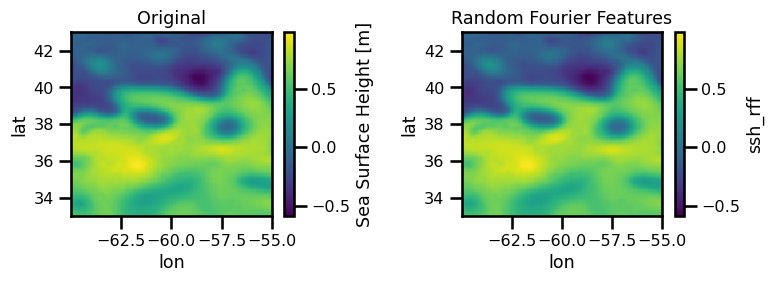

In [53]:
itime = 5

fig, ax = plt.subplots(ncols=2, figsize=(8,3))

vmin = np.min([xrda.sossheig.min(), xrda.ssh_rff.min()])
vmax = np.min([xrda.sossheig.max(), xrda.ssh_rff.max()])

xrda.sossheig.isel(time=itime).plot.pcolormesh(
    ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[0].set(title="Original")

xrda.ssh_rff.isel(time=itime).plot.pcolormesh(
    ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[1].set(title="Random Fourier Features")

plt.tight_layout()
plt.show()

In [54]:
from pint import UnitRegistry
from metpy.constants import earth_gravity as GRAVITY

def get_analysis_xr(da, g: float=GRAVITY):
    
    da.name = "ssh"
    da.attrs["units"] = "m"
    da.attrs["long_name"] = "Sea Surface Height"
    da.attrs["standard_name"] = "sea_surface_height"
    
    da.time.attrs["long_name"] = "Time"
    da.time.attrs["standard_name"] = "time"
    
    da.lon.attrs["units"] = "degrees_east"
    da.lon.attrs["long_name"] = "Longitude"
    da.lon.attrs["standard_name"] = "longitude"
    
    da.lat.attrs["units"] = "degrees_north"
    da.lat.attrs["long_name"] = "Latitude"
    da.lat.attrs["standard_name"] = "latitude"
    
    ds = da.to_dataset()
    
    dx, dy = metpy.calc.lat_lon_grid_deltas(longitude=ds.lon, latitude=ds.lat)
    
    f = metpy.calc.coriolis_parameter(latitude=np.deg2rad(ds.lat.values))
    
    f0 = f.mean()
        
    psi = (g/f0) * da 
    ds["psi"] = (("time", "lat", "lon"), psi.data)
    
    dpsi_dx, dpsi_dy = metpy.calc.geospatial_gradient(
        f=psi, latitude=ds.lat, longitude=ds.lon
    )
    
    ds["u"] = (("time", "lat", "lon"), - dpsi_dy.magnitude)
    ds["u"].attrs["units"] = dpsi_dy.u
    ds["u"].attrs["long_name"] = "Zonal Velocity"
    ds["u"].attrs["standard_name"] = "zonal_velocity"
    
    ds["v"] = (("time", "lat", "lon"), dpsi_dx.magnitude)
    ds["v"].attrs["units"] = dpsi_dx.u
    ds["v"].attrs["long_name"] = "Meridional Velocity"
    ds["v"].attrs["standard_name"] = "meridional_velocity"
    
    
    q = metpy.calc.geospatial_laplacian(f=psi, latitude=ds.lat, longitude=ds.lon)
    q /= f0
    ds["q"] = (("time", "lat", "lon"), q.values)
    ds["q"].attrs["units"] = q.data.u
    ds["q"].attrs["long_name"] = "Relative Vorticity"
    ds["q"].attrs["standard_name"] = "relative_vorticity"
        
    return ds

In [58]:
def plot_analysis(ds, time: int=0):
    
    fig, ax = plt.subplots(ncols=4, figsize=(20,4))
    
    ds.ssh.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", robust=True)
    ds.u.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="gray", robust=True)
    ds.v.isel(time=time).plot.pcolormesh(ax=ax[2], cmap="gray", robust=True)
    ds.q.isel(time=time).plot.pcolormesh(ax=ax[3], cmap="RdBu_r", robust=False)
    
    plt.tight_layout()
    plt.show()

#### NATL60 Simulation

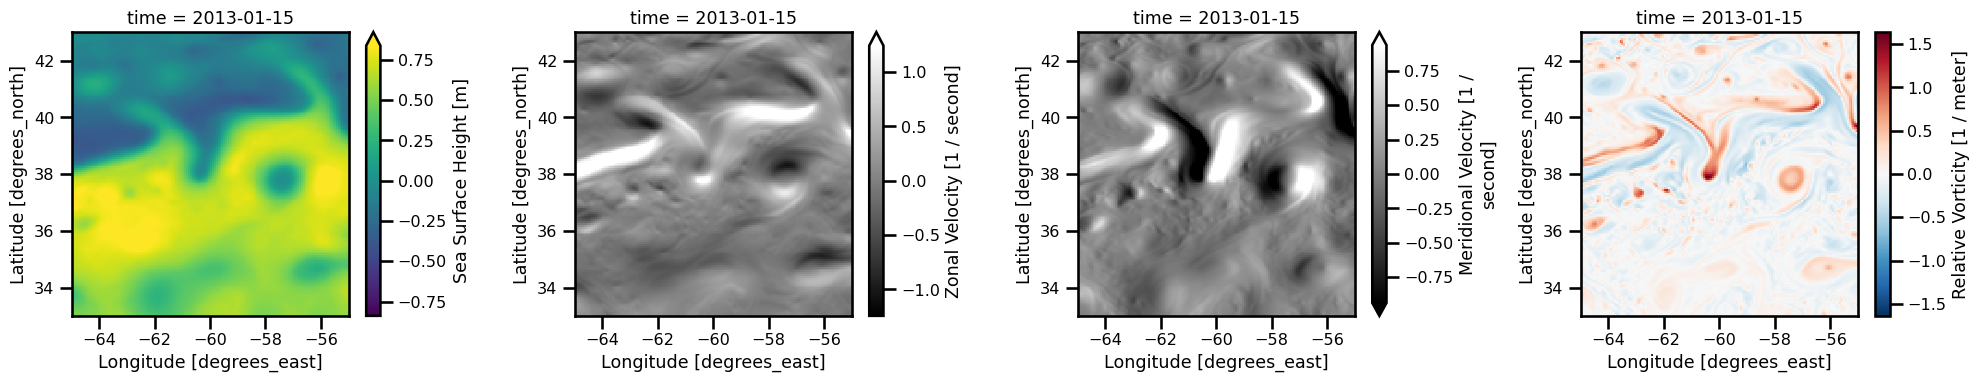

In [63]:
ds_ssh_analysis = get_analysis_xr(xrda.sossheig)

plot_analysis(ds_ssh_analysis, time=-1)

#### Latent Modulated SIREN

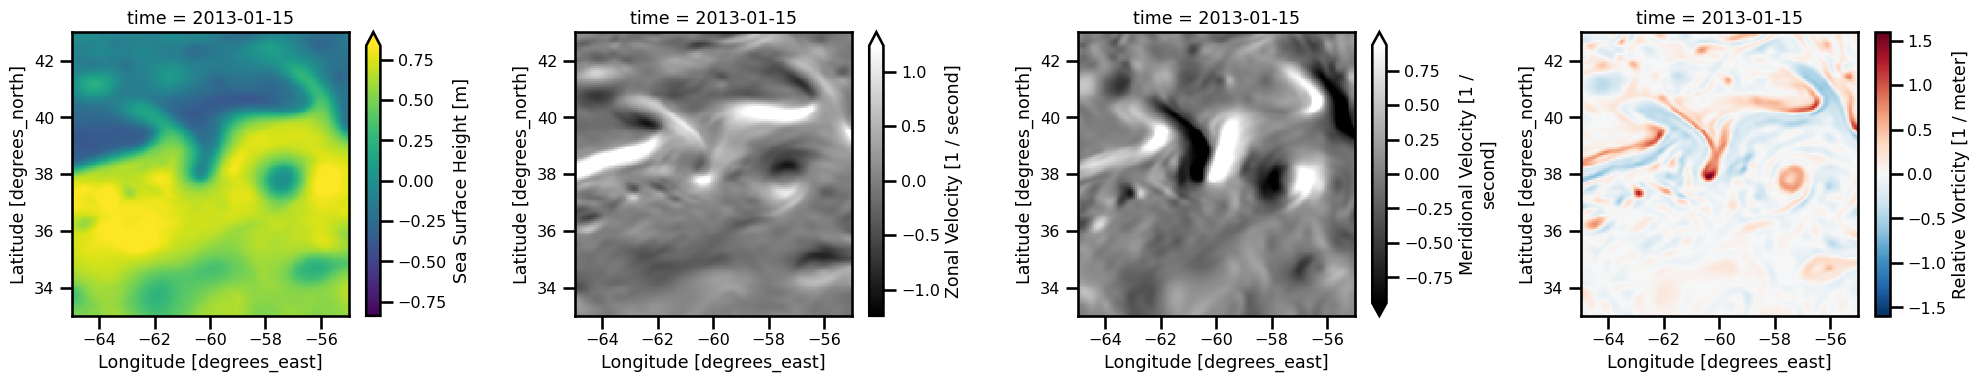

In [64]:
ds_lmodsiren_analysis = get_analysis_xr(xrda.ssh_rff)

plot_analysis(ds_lmodsiren_analysis, time=-1)